# HiredScore Data Science Home Assingment - Nathan Esra

## Design document and code implementation

### Table of Contents
* [1. Problem Statement](#1)
* [2. EDA and preprocessing](#2)
* [3. Analysis of kpi and metrics](#3)
* [4. Feature extraction](#4)
* [5. Modeling](#5)
* [6. Performance analysis](#6)
* [7. Discussion](#7)
* [8. Pipeline and example](#8)

### 1. Problem Statement <a class="anchor" id="1"></a>

You are given a JSON data file containing a list of movies, their plot summaries, and their genres. Each line of the file is a separate JSON object, representing one movie.
Each movie object contains the movie title, a plot summary, genres, and a few other fields.

Based on the JSON data file, write an ML solution for movie genre predictions. A method that takes an arbitrary movie plot and guesses the genre(s) of the movie, while providing a level of certainty.
For example, given the plot “Five teens walk into a creepy forest to be butchered by an evil psychopath” should output something like “Horror (85%), drama (20%)”.

### 2. EDA and preprocessing <a class="anchor" id="2"></a>

In [1]:
# importing relevant libraries
import re
import csv
import json
import nltk

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# function for reading json file containing list of json objects into DataFrame with each row represnting 1 movie

PATH_TO_JSON = "train.json"

def split_large_json(input_file):
    with open(input_file) as file:
        json_data = file.read()
    
    json_objects = json.loads("[" + json_data.replace("}\n{", "},{") + "]")
    
    movies = []

    for i, json_object in tqdm(enumerate(json_objects)):
        output_file = f"file{i + 1}.json"
        movies.append(json_object)
    return pd.DataFrame(movies)

movies = split_large_json(PATH_TO_JSON)
movies.head(60)

30000it [00:00, 1192049.04it/s]


,languages,genres,title,release_date,countries,movie_box_office_revenue,plot_summary,feature_length
0,{'/m/07c9s': 'Tamil Language'},{'/m/07s9rl0': 'Drama'},Periya Idathu Penn,1963,{'/m/03rk0': 'India'},,Murugappa is a small time farm labourer who l...,
1,{'/m/02h40lc': 'English Language'},"{'/m/01jfsb': 'Thriller', '/m/02n4kr': 'Myster...",The Flock,2007,{'/m/09c7w0': 'United States of America'},,A hyper-vigilant agent of the Department of Pu...,96.0
2,{'/m/03k50': 'Hindi Language'},"{'/m/02kdv5l': 'Action', '/m/07s9rl0': 'Drama'}",Gang,2000-04-14,{'/m/03rk0': 'India'},,"Four friends- Gangu , Abdul , Nihal and Gary ...",
3,"{'/m/07qv_': 'Tagalog language', '/m/01jb8r': ...","{'/m/0hn10': 'LGBT', '/m/07s9rl0': 'Drama', '/...",Daybreak,2008-02-20,{'/m/05v8c': 'Philippines'},,A married man is having an affair with another...,85.0
4,{'/m/02h40lc': 'English Language'},"{'/m/06cvj': 'Romantic comedy', '/m/02l7c8': '...",Tomboy,1985-01-25,{'/m/09c7w0': 'United States of America'},14100000,"The movie concerns the life of Tomasina ""Tommy...",91.0
5,{'/m/07c9s': 'Tamil Language'},{'/m/02kdv5l': 'Action'},Thambikottai,2011-02-11,{'/m/03rk0': 'India'},,Azhagiri and his sister Shanmughapriya are s...,150.0
6,{'/m/02h40lc': 'English Language'},{'/m/07s9rl0': 'Drama'},Knight Rider 2010,1994-02-13,{'/m/09c7w0': 'United States of America'},,"In a Mad Max style future, Jake McQueen is the...",92.0
7,{'/m/02h40lc': 'English Language'},"{'/m/04t36': 'Musical', '/m/01g6gs': 'Black-an...",Colleen,1936-03-21,{'/m/09c7w0': 'United States of America'},,"Colleen is the manager of a dress shop named ""...",89.0
8,{},"{'/m/07s9rl0': 'Drama', '/m/0219x_': 'Indie'}",Slackistan,2010,"{'/m/07ssc': 'United Kingdom', '/m/05sb1': 'Pa...",,A young man in his early twenties juggles his ...,87.0
9,{'/m/03_9r': 'Japanese Language'},"{'/m/0vgkd': 'Black comedy', '/m/0gsy3b': 'Sex...",Odd Obsession,1959-06-23,{'/m/03_3d': 'Japan'},,A man who suspects his wife is having an affai...,107.0


The json input file has been read and and transformed into a DataFrame. On first inspection, we can see that the dataset contains features which will require preprocessing:

- there appears to missing entries in the dataset
- the features "languages", "genres" and "countries" have data in the form of dictionaries and will need to be transformed and encoded to be included in the model.

In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   languages                 29922 non-null  object
 1   genres                    29922 non-null  object
 2   title                     29922 non-null  object
 3   release_date              29922 non-null  object
 4   countries                 29922 non-null  object
 5   movie_box_office_revenue  29922 non-null  object
 6   plot_summary              30000 non-null  object
 7   feature_length            29922 non-null  object
dtypes: object(8)
memory usage: 1.8+ MB


From the initial expection of the dataset, I noticed that some features contain missing values that are not in already in the form of "nan". 

examples are:
    - "languages" in row 17 and "genres" in row 16 - both conatain empty dictionaries
    - "movie_box_office_revenue" conatains many empty string
    
The first look at missing values shows that all featrues except for "plot summary" have the same amount of missing values

In [4]:
movies[movies['genres'].isnull()]

,languages,genres,title,release_date,countries,movie_box_office_revenue,plot_summary,feature_length
178,NaN,NaN,NaN,NaN,NaN,NaN,"A star quarterback, Nick Bonelli isn't told by...",NaN
1590,NaN,NaN,NaN,NaN,NaN,NaN,"{{plot|date""Eggertson"">{{cite web}} news clip ...",NaN
1634,NaN,NaN,NaN,NaN,NaN,NaN,"At night in her bayside mansion, wheelchair-bo...",NaN
1964,NaN,NaN,NaN,NaN,NaN,NaN,An Italian submarine captain tries to navigat...,NaN
3058,NaN,NaN,NaN,NaN,NaN,NaN,"Captain Eddie Gordon, a top gun pilot of air f...",NaN
...,...,...,...,...,...,...,...,...
26960,NaN,NaN,NaN,NaN,NaN,NaN,Hipolito is a blind cabaret pianist who comes ...,NaN
28179,NaN,NaN,NaN,NaN,NaN,NaN,The chipmunks Chip and Dale wake up one winter...,NaN
29150,NaN,NaN,NaN,NaN,NaN,NaN,"A film unit goes for a shoot in a forest, but ...",NaN
29268,NaN,NaN,NaN,NaN,NaN,NaN,In need of money to help her divorced boyfrien...,NaN


It appears that all of the missing values in target correspond to missing values in rest of the dataset

In [5]:
movies_null = movies[movies['genres'].isnull()]
movies = movies[~movies['genres'].isnull()]
movies[movies['genres'].isnull()]

,languages,genres,title,release_date,countries,movie_box_office_revenue,plot_summary,feature_length


Removing missing values from the target has seemingly removed all missing values from the dataset.

movies_null is a dataset containing the drop rows which have missing values. This dataset can potentially be used and example/demo for inference

Before considering other types of missing values in dataset, I must tranform features containing dictionary entires to extract their values

In [6]:
movies['languages'] = movies['languages'].apply(lambda a: list(a.values()))
movies['genres'] = movies['genres'].apply(lambda a: list(a.values()))
movies['countries'] = movies['countries'].apply(lambda a: list(a.values()))

In [7]:
movies.head(60)

,languages,genres,title,release_date,countries,movie_box_office_revenue,plot_summary,feature_length
0,[Tamil Language],[Drama],Periya Idathu Penn,1963,[India],,Murugappa is a small time farm labourer who l...,
1,[English Language],"[Thriller, Mystery, Crime Fiction, Drama, Crim...",The Flock,2007,[United States of America],,A hyper-vigilant agent of the Department of Pu...,96.0
2,[Hindi Language],"[Action, Drama]",Gang,2000-04-14,[India],,"Four friends- Gangu , Abdul , Nihal and Gary ...",
3,"[Tagalog language, Filipino language, English ...","[LGBT, Drama, Filipino Movies, World cinema]",Daybreak,2008-02-20,[Philippines],,A married man is having an affair with another...,85.0
4,[English Language],"[Romantic comedy, Romance Film, Indie, Comedy]",Tomboy,1985-01-25,[United States of America],14100000,"The movie concerns the life of Tomasina ""Tommy...",91.0
5,[Tamil Language],[Action],Thambikottai,2011-02-11,[India],,Azhagiri and his sister Shanmughapriya are s...,150.0
6,[English Language],[Drama],Knight Rider 2010,1994-02-13,[United States of America],,"In a Mad Max style future, Jake McQueen is the...",92.0
7,[English Language],"[Musical, Black-and-white]",Colleen,1936-03-21,[United States of America],,"Colleen is the manager of a dress shop named ""...",89.0
8,[],"[Drama, Indie]",Slackistan,2010,"[United Kingdom, Pakistan]",,A young man in his early twenties juggles his ...,87.0
9,[Japanese Language],"[Black comedy, Sex comedy, Comedy-drama, Drama...",Odd Obsession,1959-06-23,[Japan],,A man who suspects his wife is having an affai...,107.0


Looking at the dataset again, I can still see some missing values that are not already in the form of "nan". They can possibly be in the form of empty strings or empty lists

In [8]:
movies = movies.replace({'': np.nan})
movies = movies.applymap(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29922 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   languages                 26223 non-null  object
 1   genres                    29643 non-null  object
 2   title                     29922 non-null  object
 3   release_date              28061 non-null  object
 4   countries                 27568 non-null  object
 5   movie_box_office_revenue  5379 non-null   object
 6   plot_summary              29922 non-null  object
 7   feature_length            25255 non-null  object
dtypes: object(8)
memory usage: 2.1+ MB


More missing values have been introduced into the target

In [10]:
movies = movies[~movies['genres'].isnull()]
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29643 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   languages                 26031 non-null  object
 1   genres                    29643 non-null  object
 2   title                     29643 non-null  object
 3   release_date              27852 non-null  object
 4   countries                 27375 non-null  object
 5   movie_box_office_revenue  5376 non-null   object
 6   plot_summary              29643 non-null  object
 7   feature_length            25151 non-null  object
dtypes: object(8)
memory usage: 2.0+ MB


I have removed all missing values in the target

I have noticed that the feature "movie_box_office_revenue" contains a majority of "nan" values. I have thus decided to not include this feature in the model

The missing values in the dataset are less trivial to handle. For example, if sample is missing its entreis for languages and countries, it is difficult to use either to impute the missing values. 
- One can possibly impute language/s from countries and vice versa but without perfect accuracy. 
- for features such as title and feature length one can't impute based on the data.
- its possible that one can impute the missing data from external sources
- I present 2 options:
    1. ignore all features other plot summaries
    2. drop all samples that contain missing values and then encode the rest of the features
        - this is only valid if there is enough data after dropping samples and does not provide a solution for making inference when there is missing data

- I have chosen option 1 for simplicity and for maintaining the size of the dataset

### 3. Analysis of kpi and metrics <a class="anchor" id="3"></a>

In [11]:
movies['genres'].value_counts()

[Drama]                                                                                   1882
[Comedy]                                                                                   602
[Short Film]                                                                               362
[Horror]                                                                                   327
[Documentary]                                                                              324
                                                                                          ... 
[Thriller, Crime Fiction, Mystery, Drama, Political thriller, Action, Political drama]       1
[Remake, Romance Film, Drama, Black-and-white, Film adaptation]                              1
[Thriller, Horror, Chinese Movies]                                                           1
[Mystery, Comedy film, Horror]                                                               1
[LGBT, Family Drama, Drama, Indie]                

As can be seen above, treating the list of labels for a movie as a single label, creates a large and imbalance set of labels

In [12]:
genres = [item for sublist in movies['genres'].to_list() for item in sublist]
print('there are', len(set(genres)), 'unique genres')

there are 356 unique genres


In [13]:
pd.Series(genres).value_counts()

Drama                       13547
Comedy                       7431
Romance Film                 4738
Thriller                     4594
Action                       4137
                            ...  
Ninja movie                     1
Private military company        1
Neorealism                      1
Breakdance                      1
Plague                          1
Length: 356, dtype: int64

In [14]:
(pd.Series(genres).value_counts() <= 10).sum()

126

Looking at the data above we can see that their are 356 unique movie genres.

I made the decision to keep hybrid genres such as "Romantic comdey" instead of mapping to "Romance", "Comedy". There are a few instances like this however there is no technical rule for how this should be handled.
A note on this is that the value count of indivudal labels shows very strong imbalance across the classes with the genre "Drama" occuring 13547 and more than a third of the labels occuring 10 times or less.

There were also instances were a movie had no genre. I treated this as missing data and removed these instances and instead of created a "no genre" label. Again, there is no technical rule for this.

For a mult-label problem such as such this, I have chosen encode the target by treating each label as binary encoded target instead of encoding the list of genres per movie as a label. This decision results in a smaller and less imbalanced set of labels

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies['genres'])
sorted_labels = np.array(sorted(multilabel_binarizer.classes_))
multilabel_binarizer.classes_ = sorted_labels

y = pd.DataFrame(multilabel_binarizer.transform(movies['genres']), columns= multilabel_binarizer.classes_)

The metrics that I have chosen to measure the performance of the model are the macro averaged f1 score and the weighted f1 score.

The macro averaged f1 score should give a good reflection of the performance of the model wihtout biasing the evaluation based on the label imbalance.

The weighted f1 score will measure the performance of the model by giving weight to number of occurances for a speicific class

The two metrics together are useful in measuring how good model is, while both ignoring and considering the significant class imablance.

### 4. Feature extraction <a class="anchor" id="4"></a>

Feature extraction is going to look at how to encode the plot summaries into meaningful numeric information that can be used in the model.

In order the to this most effectively, the langugage in the summaries must first be processed

In [16]:
# function for text cleaning 
def clean_text(text):
    text = re.sub("\'", "", text) 
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = ' '.join(text.split()) 
    text = text.lower() 
    return text
movies['plot_summary'] = movies['plot_summary'].apply(lambda x: clean_text(x))

In [17]:
all_words = ' '.join([text for text in movies['plot_summary']]) 
all_words = all_words.split() 
pd.Series(all_words).value_counts().head(60)

the       579814
to        339489
and       322850
a         266065
of        183691
is        158074
in        156393
his       138444
he        123970
her       107150
with       98576
that       97865
him        68525
for        67000
by         65057
she        65053
as         62502
on         59048
they       51103
but        50804
who        49727
at         45051
from       42670
an         40720
has        39977
their      37506
it         37357
are        35872
when       35265
after      31399
out        30632
up         27956
into       27762
them       25032
be         24920
was        23307
one        22538
not        21590
then       21537
which      19270
while      18845
this       18087
about      18064
back       17404
have       16873
all        15971
where      15827
two        15776
will       15318
film       14369
tells      13379
father     13218
man        13206
had        12944
time       12925
off        12888
life       12343
new        12249
love       122

The count of words shown above shows that stopwords are the most common words found the in the summaries. These words are not meaningful in the context of predicting genre and will thus be removed

In [18]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies['plot_summary'] = movies['plot_summary'].apply(lambda x: remove_stopwords(x))

In [19]:
all_words = ' '.join([text for text in movies['plot_summary']]) 
all_words = all_words.split() 
pd.Series(all_words).value_counts().head(60)

one         22538
back        17404
two         15776
film        14369
tells       13379
father      13218
man         13206
time        12925
life        12343
new         12249
love        12228
get         12142
home        11882
also        11492
find        11411
house       11329
however     11225
finds       11038
later       10947
family      10933
go          10169
goes         9994
takes        9891
mother       9835
day          9783
police       9388
young        9241
away         9200
take         8934
first        8933
wife         8656
tries        8603
gets         8589
help         8506
night        8287
old          8010
son          8008
friends      7486
begins       7474
money        7465
story        7461
way          7448
death        7343
next         7306
friend       7281
becomes      7253
make         7186
killed       7106
comes        7030
car          6996
woman        6996
another      6950
soon         6939
men          6934
years        6870
decides   

To process the text further, I will lemmatize the summaries. This will contribute to accuracy of the model by reducing the vocabulary size and extracting more meaningful representations of the words. 
Lemmatization was chosen over stemming as it should produce more accurate word representations by consideration the context. Time is also not a huge factor at this level as the dataset isn't too big and the lemmatization only needs to occur once for training

In [20]:
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_words)

movies['plot_summary'] = movies['plot_summary'].apply(lemmatize_text)

Now splitting the data before fit a feature extraction. This is done at this point to avoid data leakage.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(movies['plot_summary'], y, test_size=0.2, random_state=0)

In [22]:
summary_lenths = [len(i) for i in movies['plot_summary']]
print('min:', min(summary_lenths))
print('max:', max(summary_lenths))
print('mean:', np.mean(summary_lenths))

min: 45
max: 17644
mean: 1170.624228316972


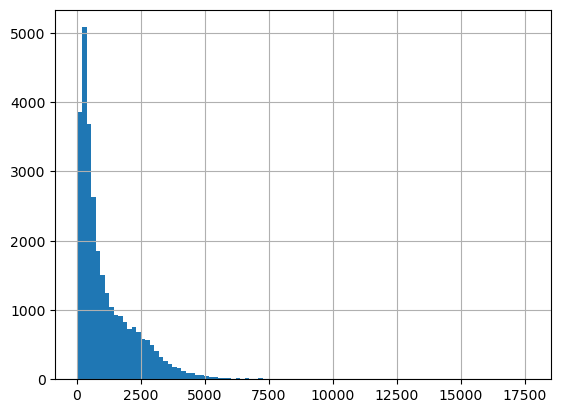

In [23]:
pd.Series([len(i) for i in movies['plot_summary']]).hist(bins=100)
plt.show()

The plot above shows the distribution of lenths of the processed plot summaries. They are not particularly long with the shortest summary being 45 words and the mean being lenth being 1170. 

Since most summaries are distributed on the shorter side and for simplicity, I have decided to vectorize the features using tfidf.

I wil note that there is an argument to use a word embedding like word2vec which can be in improve the model by capturing the context of summaries in vector form. 

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
X_train = tfidf_vectorizer.fit_transform(X_train)
X_val = tfidf_vectorizer.transform(X_val)

### 5. Modeling <a class="anchor" id="5"></a>

To model this problem, one has to use a modeling technique stuiable for mutli-label classification. I have chosen the one vs rest classifier for this problem and it wil be implemented using LogisticiRegression. This combination is a good choice for this problem espeically in a time and compute constrained environment

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

lr = LogisticRegression()

clf = OneVsRestClassifier(lr)
clf.fit(X_train, y_train)

/Users/nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 48 is present in all training examples.
  warnings.warn(
/Users/nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 60 is present in all training examples.
  warnings.warn(
/Users/nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 69 is present in all training examples.
  warnings.warn(
/Users/nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_opti

OneVsRestClassifier(estimator=LogisticRegression())

### 6. Performance analysis <a class="anchor" id="6"></a>

In [26]:
y_probas = pd.DataFrame(clf.predict_proba(X_val), columns=multilabel_binarizer.classes_)
y_pred = clf.predict(X_val)

In [27]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         0
           2       0.70      0.25      0.36       838
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        58
           5       0.62      0.12      0.20       488
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00        16
           8       0.63      0.11      0.18       431
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00         2
          17       0.00    

/Users/nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Making infrerence on the validataion set we get the following metrics:
- f1 (weighted): 0.25  (precision: 0.54 recall: 0.19)
- f1 (macro average): 0.02 (precision: 0.08 recall: 0.02)

The macro averaged f1 score of 0.02, indicates that the model did a very poor job of accurately clasifiying the positive predictions overall, having no consideration for the class imbalance.

When looking at the weighted f1 score, we see significant improvement with a score of 0.25 and precision and recall of 0.54 and 0.19 respectively. 

The difference between these two scores is that the weighted f1 gives a higher weight to classes mith more occurances. I interpret this to mean that the model did not perform well on classes that had too little occurances and it performed a lot better where there were more occurances in the classes. 
By looking at the classification report one can see that the model performs significantly better when the support ie. number of occurances in the class is higher.

In [28]:
t = 0.17 # threshold value
y_pred_threshold = (y_probas >= t).astype(int)
print(classification_report(y_val, y_pred_threshold))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         0
           2       0.44      0.78      0.56       838
           3       0.00      0.00      0.00        17
           4       0.40      0.03      0.06        58
           5       0.39      0.60      0.47       488
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00        16
           8       0.41      0.54      0.46       431
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00         2
          17       0.00    

/Users/nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


By adjusting the probablity threshold for the predictions, we get an improvement in the measurements
- f1 (weighted): 0.4  (precision: 0.39 recall: 0.50)
- f1 (macro average): 0.09 (precision: 0.09 recall: 0.05)

The increase in the weighted f1 is significant. It has changed the model to make positive predictions more often however, slightly less reliably.
The increase in the macro averaged f1 is negligable

Making predicitons with confidence intervals
- the confidence intervals that are shown her are confidences higher than the current threshold of 0.17

In [29]:
decoded_labels = multilabel_binarizer.inverse_transform(y_pred_threshold.values)
predictions_with_confidence = []
for i, ele in enumerate(decoded_labels):
    top_predictions = y_probas[list(ele)].iloc[i].to_dict()
    sorted_predictions = {k: v for k, v in sorted(top_predictions.items(), key=lambda item: item[1], reverse=True)}
    predictions_with_confidence.append(sorted_predictions)

In [30]:
predictions_with_confidence

[{'Crime Fiction': 0.6239832596404942,
  'Drama': 0.44069987257230636,
  'Action': 0.3749370960058187,
  'Black-and-white': 0.36689405471233955,
  'Thriller': 0.36637269204295403,
  'Comedy': 0.18806868402544288},
 {'Drama': 0.46266738345683067},
 {'Romance Film': 0.612690595824439,
  'Comedy': 0.450022370707428,
  'Drama': 0.2525566085684669},
 {'Comedy': 0.5174578379072858, 'Drama': 0.26993457813598165},
 {'Comedy': 0.5526958379367021, 'Drama': 0.5418799635395077},
 {'Romance Film': 0.5627182427131341,
  'Drama': 0.46140366191092064,
  'Black-and-white': 0.33754891432172884,
  'Comedy': 0.24847294475093973},
 {'Adventure': 0.3891695598461263, 'Fantasy': 0.3831980533166277},
 {'Drama': 0.4545611132390375,
  'Adventure': 0.26759450529984496,
  'Action': 0.17769011385519584,
  'Romance Film': 0.17660591269649634},
 {'Crime Fiction': 0.49196702781272766,
  'Thriller': 0.3576354066993758,
  'Action': 0.25926996183394496,
  'Drama': 0.22244332676271908,
  'Mystery': 0.19310237169472166,
  

### 7. Discussion <a class="anchor" id="7"></a>

Given plot summaries of movies and their genre/s one is able to build a machine learning model to predict the genre/s.

Overall the model was not at good correclty prediciting genres across all classes but showed improvement when only considering classes with higher occurances. 

There is a lot of room for improvement of this model.
- one of the model's biggest shortcomings was its ability to predict very imbalanced classes. By enriching the data with more samples espiecally for classes with low occurances, this can be improved.
- a deeper analysis and effort can be placed on filling the missing values from external sources in order to leverage the information in the other features
- on another attempt, one should look into using more advanced word embeddings such as word2vec in order to capture context in the vectorization step
- on the modelling front, with more resources, one could use more powerful models such fine tuning a pretrained network.

### 8. Pipeline and example<a class="anchor" id="8"></a>

In [31]:
def clean_text(text):
    text = re.sub("\'", "", text) 
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = ' '.join(text.split()) 
    text = text.lower() 
    return text


def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)


def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_words)


class Pipeline:


    def __init__(self, vectorizer, model, threshold, classes):
        self.vectorizer = vectorizer
        self.model = model
        self.threshold = threshold
        self.classes = classes

    def process_data(self, data):
        data = data.apply(lambda x: clean_text(x))
        data = data.apply(lambda x: remove_stopwords(x))
        data = data.apply(lemmatize_text)
        X = self.vectorizer.transform(data)
        return X
    
    def make_predictions(self, X):
        y_proataFrbas = pd.Dame(self.model.predict_proba(X), columns=self.classes)
        y_pred_threshold = (y_probas >= self.threshold).astype(int)
        
        decoded_labels = multilabel_binarizer.inverse_transform(y_pred_threshold.values)
        
        predictions_with_confidence = []
        for i, ele in enumerate(decoded_labels):
            top_predictions = y_probas[list(ele)].iloc[i].to_dict()
            sorted_predictions = {k: v for k, v in sorted(top_predictions.items(), key=lambda item: item[1], reverse=True)}
            predictions_with_confidence.append(sorted_predictions)
        
        return predictions_with_confidence

Using the pipeline to make inference on the movies_null dataset (from earlier)

In [32]:
pipeline = Pipeline(tfidf_vectorizer, clf, 0.17, multilabel_binarizer.classes_)
processed = pipeline.process_data(movies_null['plot_summary'])
pipeline.make_predictions(processed)

[{'Drama': 0.548818555576306,
  'Comedy': 0.4475226234326711,
  'Sports': 0.22093501963089218,
  'Thriller': 0.1972403529518631},
 {'Comedy': 0.25522020143088997},
 {'Horror': 0.6811214016999132,
  'Thriller': 0.5669058198165309,
  'Drama': 0.4278340595028853,
  'Mystery': 0.3285143219931999,
  'Crime Fiction': 0.17865739053035992},
 {'Drama': 0.6037687065015459,
  'War film': 0.4119936257009697,
  'Black-and-white': 0.18722435362105996},
 {'Drama': 0.569528034084405,
  'Thriller': 0.5642885220825101,
  'Action': 0.44893291931970725,
  'Action/Adventure': 0.3372448844797553,
  'Crime Fiction': 0.2876036460255976,
  'Romance Film': 0.19253471334713348},
 {'Documentary': 0.4285361714174887, 'Drama': 0.3606327822366395},
 {'Drama': 0.47891435043431574,
  'Comedy': 0.39960500261323606,
  'Black-and-white': 0.2986711085565856,
  'World cinema': 0.24214926951955615,
  'Romance Film': 0.2106292950041846,
  'Musical': 0.20191845655360344},
 {'Drama': 0.7544826430942293,
  'Comedy': 0.361299121